# Identifying and quantifying events

This notebook uses toy examples to show how to work with timewizard's event detection functionality.

In [1]:
import numpy as np
import timewizard.perievent as tw
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

These functions take a one-D, binarized sigal (e.g. 0's and 1's), along with its timestamps, and return information about the timing of events (i.e., when the signal transitioned from 0 to 1). 

Features include:
* returns a neat table with start / stop / duration statistics.
* specify a minimum block spacing; runs of 1's interrupted by runs of 0's which are shorter than the minimum spacing will be combined.
* easily transform a list of times into a list of "times from previous event" or "time to next event".


Let's return to our data from the first example, with an animal running in a circle.

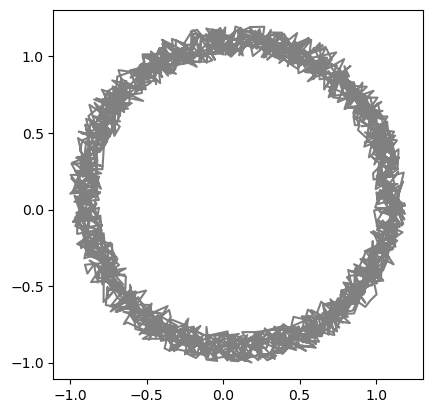

In [2]:
np.random.seed(10)

fs = 30  # Hz
t = np.arange(0, 20*np.pi, 1/fs)  
x = np.cos(t) + np.random.random(t.shape) * 0.2
y = np.sin(t) + np.random.random(t.shape) * 0.2
data = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])
plt.plot(data[:,0], data[:,1], color='gray')
_ = plt.axis('square')

## Identifying events

Recall that the animal preferentially vocalized around `theta=pi`. So, we decide to look at every instance where the animal passed `theta=pi`, not just the ones where it vocalized. (Perhaps we want to make some raster plots!)

If we naively find all the moments where the animal passed `theta=pi`, we will end up with some very short bouts, due to the random noise in the animal's position.

In [3]:
def plot_crossings():
    for i in range(len(crossing_idx)):
        s = slice(crossing_idx[i] - 10, crossing_idx[i] + 10)
        plt.figure(figsize=(3,2))
        plt.plot(t[s], theta[s]/np.pi, '-')
        plt.scatter(
            t[s], 
            theta[s]/np.pi, 
            c=['C1' if i in crossing_idx else 'C0' for i in range(s.start, s.stop)]
        )
        plt.axhline(1)
        plt.title(f'Crossing at t={t[crossing_idx[i]].round(1)}')
        if i == 3: break
    return

Text(0, 0.5, 'Position (units of pi)')

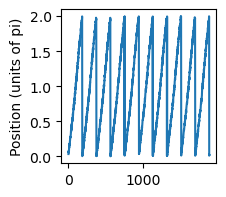

In [4]:
theta = np.arctan2(y, x)
theta[theta < 0] = theta[theta < 0] + 2*np.pi  # put into range (0, 2pi) for simplicity
rel_position_to_pi = np.vstack(
    [np.concatenate([[np.nan], theta[:-1] < np.pi]),
    theta > np.pi]
)  # moments where prev posn is less than pi and this one is greater
bool_train = (rel_position_to_pi.sum(axis=0) == 2)
crossing_idx = np.where(bool_train)[0]

plt.figure(figsize=(2,2))
plt.plot(theta/np.pi)
plt.ylabel('Position (units of pi)')

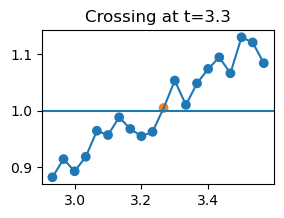

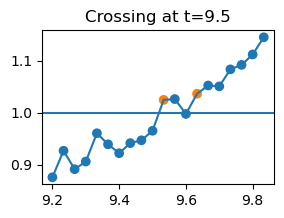

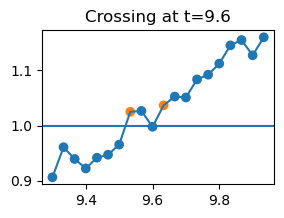

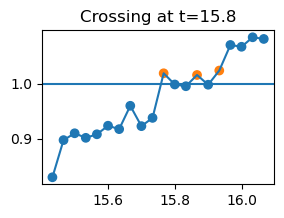

In [5]:
plot_crossings()  # only shows the first few, to save space

One way to get around this is to impose a minimum block length. Let's say that if the animal crosses back within one second of an initial crossing, then we won't count it. timewizard wraps this nicely with `tw.event_times_from_train(mode='initial_onset', block_min_spacing=x)`

In [6]:
min_spacing = 1
crossing_idx, crossing_times = tw.event_times_from_train(
    bool_train, 
    t, 
    mode='initial_onset', 
    block_min_spacing=min_spacing
)

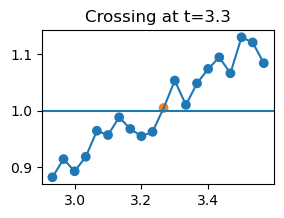

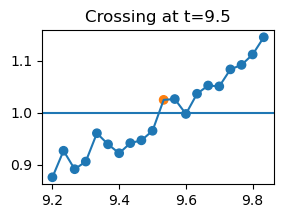

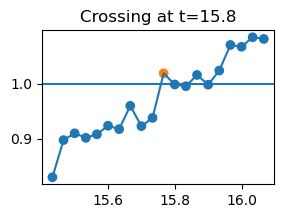

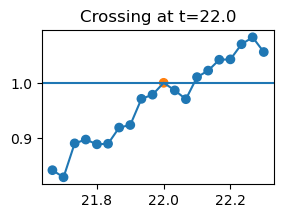

In [7]:
plot_crossings()

Much better!

## Characterizing epochs

Next, a reviewer on our paper asks if we see anything during epochs when the animal is in a certain area of the arena, say the slice from np.pi to 3*np.pi/2. If we naively find onsets and offsets, we will run into the same problem as before -- detecting overly short epochs due to noise. Again, timewizard wraps the desired behavior for you in `tw.event_epochs`.

NB: simply getting onsets + offsets with `event_times_from_train` will give the same results as `event_epochs` if there is no noise, but in noisy cases like this, `event_epochs` is careful to ensure the result has matched onsets + offsets, whereas you can end up with differeing numbers of onsets / offsets if you get them separately.

In [10]:
bool_train = (theta > np.pi) & (theta < 3*np.pi/2)
df = tw.event_epochs(bool_train, t, mode='initial_onset', block_min_spacing=min_spacing)
df

,onset_index,onset_time,offset_index,offset_time,duration,value
0,98,3.266667,139,4.633333,1.366667,1
1,286,9.533333,329,10.966667,1.433333,1
2,473,15.766667,517,17.233333,1.466667,1
3,660,22.000000,705,23.500000,1.500000,1
4,852,28.400000,893,29.766667,1.366667,1
5,1041,34.700000,1080,36.000000,1.300000,1
6,1229,40.966667,1270,42.333333,1.366667,1
7,1416,47.200000,1457,48.566667,1.366667,1
8,1605,53.500000,1648,54.933333,1.433333,1
9,1794,59.800000,1833,61.100000,1.300000,1


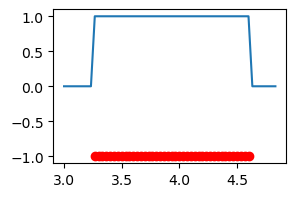

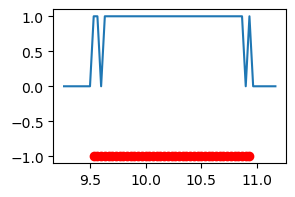

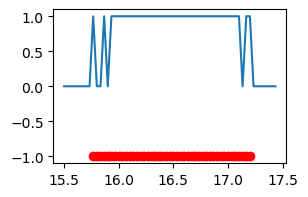

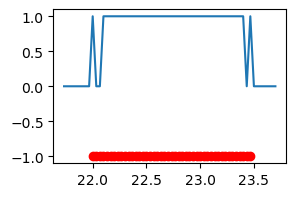

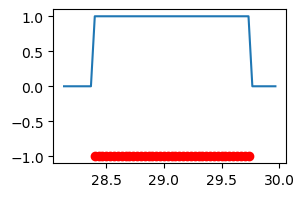

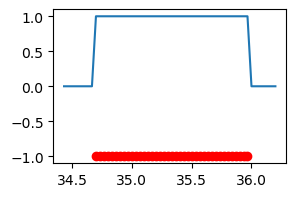

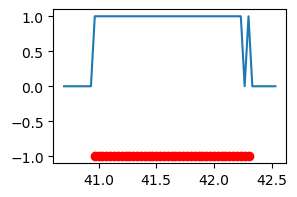

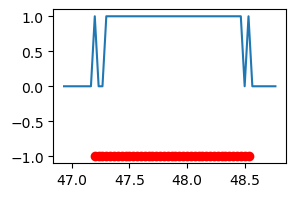

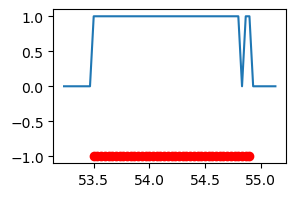

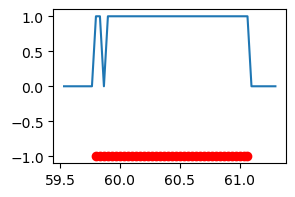

In [11]:
for i in range(len(df)):
    s = slice(int(df.loc[i, 'onset_index'] - fs/4), int(df.loc[i, 'offset_index'] + fs/4))
    plt.figure(figsize=(3,2))
    plt.plot(t[s], bool_train[s], '-')
    xvals = t[range(df.loc[i, 'onset_index'], df.loc[i, 'offset_index'])]
    plt.scatter(xvals ,np.repeat(-1, len(xvals)), c='r')
